mobilenet_v2

Classes: ['ASD', 'Normal', 'PDA', 'VSD']
Validation set size: 166
✅ Model loaded from: models/mobilenet_v2.pth


/tmp/ipykernel_317023/1426819353.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)



✅ Validation Accuracy: 0.9639

📋 Classification Report:
              precision    recall  f1-score   support

         ASD     1.0000    0.9722    0.9859        36
      Normal     0.9750    1.0000    0.9873        39
         PDA     0.9800    0.9245    0.9515        53
         VSD     0.9024    0.9737    0.9367        38

    accuracy                         0.9639       166
   macro avg     0.9644    0.9676    0.9654       166
weighted avg     0.9654    0.9639    0.9640       166



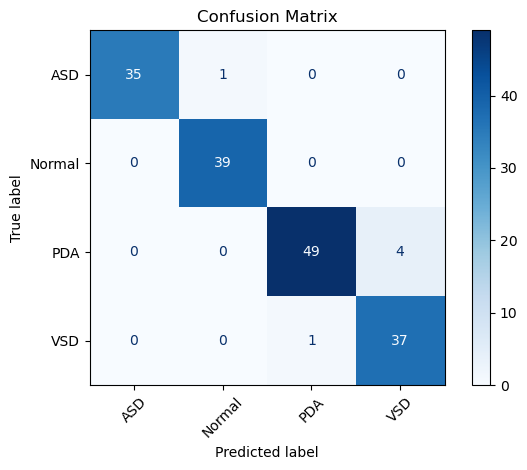


📈 ROC/AUC (one-vs-rest):
  • ASD AUC: 1.0000
  • Normal AUC: 1.0000
  • PDA AUC: 0.9980
  • VSD AUC: 0.9988
  • Micro-average AUC: 0.9988
  • Macro-average AUC: 0.9992


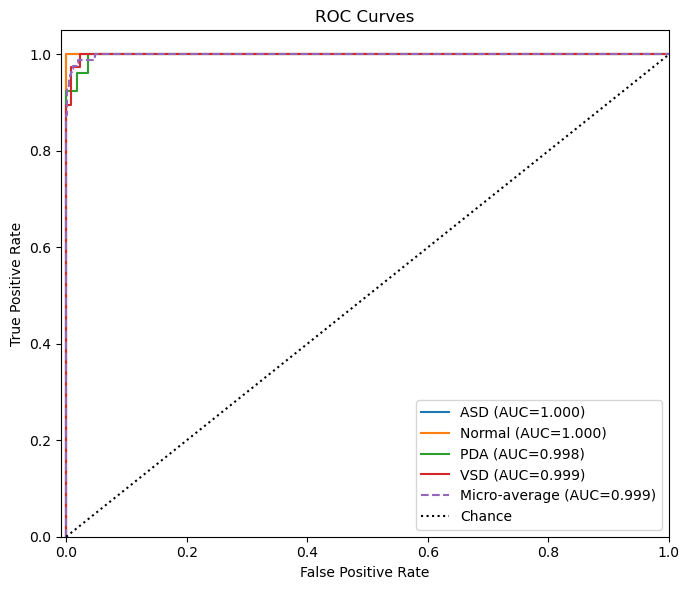

📁 Saved files:
  - validation_confusion_matrix.csv
  - validation_classification_report.csv
  - validation_roc_curves.csv
  - validation_roc_auc_summary.csv
  - validation_roc_curve.png


In [10]:
import os
import yaml
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torchvision import datasets, transforms, models
from torch.utils.data import Subset, DataLoader
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, classification_report,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize

# ====================== CONFIG ======================
with open("config/config.yaml", "r") as f:
    config = yaml.safe_load(f)

seed = config["training"]["seed"]
data_dir = config["data"]["data_dir"]
img_size = config["data"]["image_size"]
batch_size = config["data"]["batch_size"]
checkpoint_path = "models/mobilenet_v2.pth"

# ROC plotting tweaks
LEFT_PAD = -0.008         # start x-axis slightly after 0 to “open up” the left edge
ZOOM_LEFT = False         # set True to zoom into the left region (e.g., FPR 0 to 0.2)
ZOOM_LEFT_MAX_X = 0.2     # only used if ZOOM_LEFT is True

# ====================== SEEDS ======================
torch.manual_seed(seed)
np.random.seed(seed)

# ====================== DATA ======================
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = dataset.classes
print(f"Classes: {class_names}")

indices = list(range(len(dataset)))
np.random.shuffle(indices)
split = int(0.8 * len(indices))
val_indices = indices[split:]

val_dataset = Subset(dataset, val_indices)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print(f"Validation set size: {len(val_dataset)}")

# ====================== MODEL ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.mobilenet_v2(weights=None)  # same architecture as training
model.classifier[1] = torch.nn.Linear(model.last_channel, len(class_names))

checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()
print(f"✅ Model loaded from: {checkpoint_path}")

# ====================== EVAL (preds + probs) ======================
y_true, y_pred, y_scores = [], [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)       # probabilities for ROC/AUC
        preds = torch.argmax(probs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

y_true_np = np.array(y_true)
y_score = np.vstack(y_scores)  # shape (N, n_classes)

# ====================== METRICS: ACC, REPORT, CM ======================
acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Validation Accuracy: {acc:.4f}")

print("\n📋 Classification Report:")
report_str = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report_str)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ====================== ROC / AUC (OvR) ======================
print("\n📈 ROC/AUC (one-vs-rest):")
n_classes = len(class_names)

# one-hot encode labels for ROC
y_onehot = label_binarize(y_true_np, classes=list(range(n_classes)))

fpr, tpr, roc_auc = {}, {}, {}
present_classes = []  # classes that actually appear in y_true

for i in range(n_classes):
    # skip classes with only one label (all 0s or all 1s) to avoid undefined ROC
    if y_onehot[:, i].max() == y_onehot[:, i].min():
        continue
    present_classes.append(i)
    fpr[i], tpr[i], _ = roc_curve(y_onehot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# micro-average (over present classes)
if present_classes:
    fpr["micro"], tpr["micro"], _ = roc_curve(
        y_onehot[:, present_classes].ravel(),
        y_score[:, present_classes].ravel()
    )
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
else:
    fpr["micro"], tpr["micro"], roc_auc["micro"] = None, None, np.nan

# macro-average (mean of per-class AUCs for present classes)
roc_auc["macro"] = np.mean([roc_auc[i] for i in present_classes]) if present_classes else np.nan

# print AUCs
for i in present_classes:
    print(f"  • {class_names[i]} AUC: {roc_auc[i]:.4f}")
print(f"  • Micro-average AUC: {roc_auc['micro']:.4f}")
print(f"  • Macro-average AUC: {roc_auc['macro']:.4f}")

# ====================== PLOT ROC ======================
plt.figure(figsize=(7, 6))
for i in present_classes:
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC={roc_auc[i]:.3f})")

if fpr.get("micro") is not None:
    plt.plot(fpr["micro"], tpr["micro"], linestyle="--",
             label=f"Micro-average (AUC={roc_auc['micro']:.3f})")

plt.plot([0, 1], [0, 1], "k:", label="Chance")

# Left-edge openness + optional left zoom
if ZOOM_LEFT:
    plt.xlim([LEFT_PAD, ZOOM_LEFT_MAX_X])
else:
    plt.xlim([LEFT_PAD, 1.0])

plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("validation_roc_curve.png", dpi=200)
plt.show()

# ====================== SAVE ARTIFACTS ======================
# confusion matrix
pd.DataFrame(cm, index=class_names, columns=class_names).to_csv(
    "validation_confusion_matrix.csv"
)

# classification report
pd.DataFrame(
    classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
).transpose().to_csv("validation_classification_report.csv")

# ROC curve points
roc_rows = []
for i in present_classes:
    for x, y in zip(fpr[i], tpr[i]):
        roc_rows.append({"class": class_names[i], "fpr": x, "tpr": y, "auc": roc_auc[i]})
if fpr.get("micro") is not None:
    for x, y in zip(fpr["micro"], tpr["micro"]):
        roc_rows.append({"class": "micro-average", "fpr": x, "tpr": y, "auc": roc_auc["micro"]})

pd.DataFrame(roc_rows).to_csv("validation_roc_curves.csv", index=False)

# summary metrics
pd.DataFrame({
    "metric": ["accuracy", "macro_auc", "micro_auc"],
    "value": [acc, roc_auc["macro"], roc_auc["micro"]]
}).to_csv("validation_roc_auc_summary.csv", index=False)

print("📁 Saved files:")
print("  - validation_confusion_matrix.csv")
print("  - validation_classification_report.csv")
print("  - validation_roc_curves.csv")
print("  - validation_roc_auc_summary.csv")
print("  - validation_roc_curve.png")


densenet121

✅ Classes: ['ASD', 'Normal', 'PDA', 'VSD']
✅ Validation set size: 166
✅ Model loaded from: models/densenet121.pth


/tmp/ipykernel_159471/679282885.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)



✅ Validation Accuracy: 0.9458

📋 Classification Report:
              precision    recall  f1-score   support

         ASD     0.8571    1.0000    0.9231        36
      Normal     1.0000    0.8718    0.9315        39
         PDA     0.9808    0.9623    0.9714        53
         VSD     0.9474    0.9474    0.9474        38

    accuracy                         0.9458       166
   macro avg     0.9463    0.9454    0.9433       166
weighted avg     0.9508    0.9458    0.9461       166



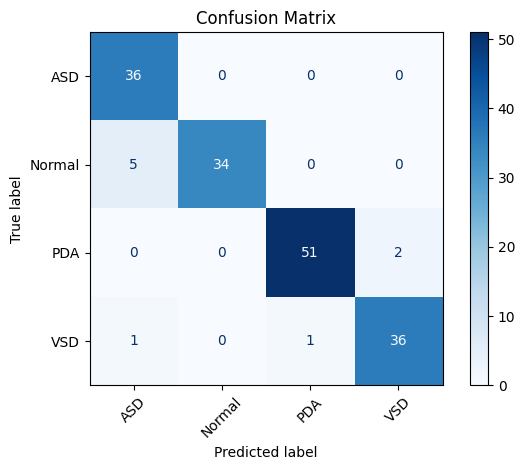

📁 Results saved: validation_confusion_matrix.csv & validation_classification_report.csv


In [14]:
import torch
import numpy as np
from torchvision import datasets, transforms, models
from torch.utils.data import Subset, DataLoader
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, classification_report)
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import os


with open("config/config.yaml", 'r') as f:
    config = yaml.safe_load(f)

seed = config['training']['seed']
data_dir = config['data']['data_dir']
img_size = config['data']['image_size']
batch_size = config['data']['batch_size']
checkpoint_path = "models/densenet121.pth"


torch.manual_seed(seed)
np.random.seed(seed)


transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = dataset.classes
print(f"Classes: {class_names}")

indices = list(range(len(dataset)))
np.random.shuffle(indices)
split = int(0.8 * len(indices))
val_indices = indices[split:]

val_dataset = Subset(dataset, val_indices)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print(f"Validation set size: {len(val_dataset)}")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = models.densenet121(weights=None)
model.classifier = torch.nn.Linear(model.classifier.in_features, len(class_names))


checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()
print(f"✅ Model loaded from: {checkpoint_path}")

# -----------------------------
# STEP 5: Evaluate model
# -----------------------------
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# -----------------------------
# STEP 6: Metrics and Save Outputs
# -----------------------------
acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Validation Accuracy: {acc:.4f}")

print("\n📋 Classification Report:")
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Save outputs
pd.DataFrame(cm, index=class_names, columns=class_names).to_csv("validation_confusion_matrix.csv")
pd.DataFrame(classification_report(y_true, y_pred, target_names=class_names, output_dict=True)).transpose().to_csv("validation_classification_report.csv")
print("📁 Results saved: validation_confusion_matrix.csv & validation_classification_report.csv")


✅ Classes: ['ASD', 'Normal', 'PDA', 'VSD']
✅ Validation set size: 166


/tmp/ipykernel_159471/3864211965.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


✅ RESNET50 model loaded from: models/resnet50.pth

✅ Validation Accuracy: 0.9578

📋 Classification Report:
              precision    recall  f1-score   support

         ASD     1.0000    0.9167    0.9565        36
      Normal     0.9268    0.9744    0.9500        39
         PDA     1.0000    0.9434    0.9709        53
         VSD     0.9048    1.0000    0.9500        38

    accuracy                         0.9578       166
   macro avg     0.9579    0.9586    0.9568       166
weighted avg     0.9610    0.9578    0.9581       166



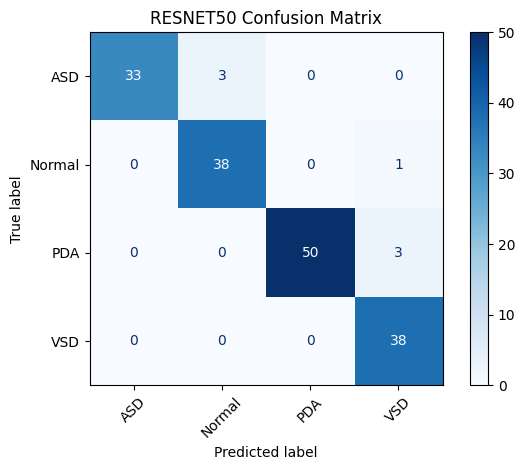

📁 Results saved: resnet50_confusion_matrix.csv & resnet50_classification_report.csv


In [31]:
import torch
import numpy as np
from torchvision import datasets, transforms, models
from torch.utils.data import Subset, DataLoader
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, classification_report)
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import os

# -----------------------------
# STEP 1: Load config
# -----------------------------
with open("config/config.yaml", 'r') as f:
    config = yaml.safe_load(f)

seed = config['training']['seed']
data_dir = config['data']['data_dir']
img_size = config['data']['image_size']
batch_size = config['data']['batch_size']

model_name = "resnet50" 
checkpoint_path = "models/resnet50.pth"


torch.manual_seed(seed)
np.random.seed(seed)

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = dataset.classes
print(f"✅ Classes: {class_names}")

indices = list(range(len(dataset)))
np.random.shuffle(indices)
split = int(0.8 * len(indices))
val_indices = indices[split:]

val_dataset = Subset(dataset, val_indices)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print(f"✅ Validation set size: {len(val_dataset)}")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if model_name == "squeezenet":
    model = models.squeezenet1_0(weights=None)
    model.classifier[1] = torch.nn.Conv2d(512, len(class_names), kernel_size=(1, 1))
    model.num_classes = len(class_names)
elif model_name == "resnet18":
    model = models.resnet18(weights=None)
    model.fc = torch.nn.Linear(model.fc.in_features, len(class_names))
elif model_name == "resnet50":
    model = models.resnet50(weights=None)
    model.fc = torch.nn.Linear(model.fc.in_features, len(class_names))
else:
    raise ValueError("Unsupported model name")

checkpoint = torch.load(checkpoint_path, map_location=device)

if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint:
    model.load_state_dict(checkpoint["model_state_dict"])
else:
    model.load_state_dict(checkpoint)

model.to(device)
model.eval()
print(f"✅ {model_name.upper()} model loaded from: {checkpoint_path}")


y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Validation Accuracy: {acc:.4f}")

print("\n📋 Classification Report:")
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title(f"{model_name.upper()} Confusion Matrix")
plt.tight_layout()
plt.show()

# Save results
pd.DataFrame(cm, index=class_names, columns=class_names).to_csv(f"{model_name}_confusion_matrix.csv")
pd.DataFrame(classification_report(y_true, y_pred, target_names=class_names, output_dict=True)).transpose().to_csv(f"{model_name}_classification_report.csv")
print(f"📁 Results saved: {model_name}_confusion_matrix.csv & {model_name}_classification_report.csv")

✅ Classes: ['ASD', 'Normal', 'PDA', 'VSD']
✅ Validation set size: 166
✅ RESNET18 model loaded from: models/resnet18.pth


/tmp/ipykernel_159471/2273261295.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)



✅ Validation Accuracy: 0.9518

📋 Classification Report:
              precision    recall  f1-score   support

         ASD     1.0000    0.8889    0.9412        36
      Normal     0.9500    0.9744    0.9620        39
         PDA     0.9455    0.9811    0.9630        53
         VSD     0.9231    0.9474    0.9351        38

    accuracy                         0.9518       166
   macro avg     0.9546    0.9479    0.9503       166
weighted avg     0.9532    0.9518    0.9516       166



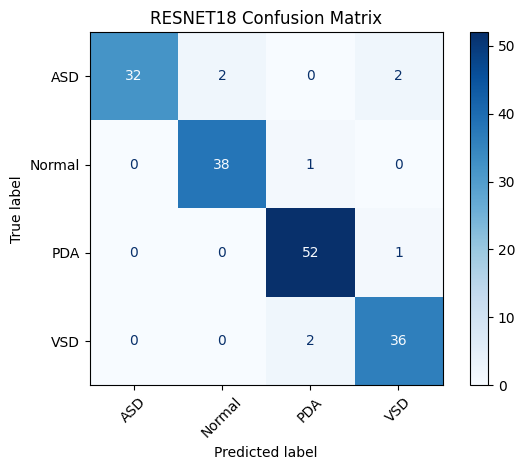

📁 Results saved: resnet18_confusion_matrix.csv & resnet18_classification_report.csv


In [ ]:
import torch
import numpy as np
from torchvision import datasets, transforms, models
from torch.utils.data import Subset, DataLoader
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, classification_report)
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import os


with open("config/config.yaml", 'r') as f:
    config = yaml.safe_load(f)

seed = config['training']['seed']
data_dir = config['data']['data_dir']
img_size = config['data']['image_size']
batch_size = config['data']['batch_size']

# 🔁 Set model and checkpoint
model_name = "resnet18"  # Options: "squeezenet", "resnet18", "resnet50"
checkpoint_path = "models/resnet18.pth"


torch.manual_seed(seed)
np.random.seed(seed)

# -----------------------------
# STEP 3: Dataset and split
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = dataset.classes
print(f"✅ Classes: {class_names}")

indices = list(range(len(dataset)))
np.random.shuffle(indices)
split = int(0.8 * len(indices))
val_indices = indices[split:]

val_dataset = Subset(dataset, val_indices)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print(f"✅ Validation set size: {len(val_dataset)}")

# -----------------------------
# STEP 4: Load model architecture
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if model_name == "squeezenet":
    model = models.squeezenet1_0(weights=None)
    model.classifier[1] = torch.nn.Conv2d(512, len(class_names), kernel_size=(1, 1))
    model.num_classes = len(class_names)
elif model_name == "resnet18":
    model = models.resnet18(weights=None)
    model.fc = torch.nn.Linear(model.fc.in_features, len(class_names))
elif model_name == "resnet50":
    model = models.resnet50(weights=None)
    model.fc = torch.nn.Linear(model.fc.in_features, len(class_names))
else:
    raise ValueError("Unsupported model name")

# -----------------------------
# STEP 5: Load checkpoint (auto-detect format)
# -----------------------------
checkpoint = torch.load(checkpoint_path, map_location=device)

if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint:
    model.load_state_dict(checkpoint["model_state_dict"])
else:
    model.load_state_dict(checkpoint)

model.to(device)
model.eval()
print(f"✅ {model_name.upper()} model loaded from: {checkpoint_path}")

# -----------------------------
# STEP 6: Evaluate model
# -----------------------------
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# -----------------------------
# STEP 7: Metrics and Save
# -----------------------------
acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Validation Accuracy: {acc:.4f}")

print("\n📋 Classification Report:")
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title(f"{model_name.upper()} Confusion Matrix")
plt.tight_layout()
plt.show()

# Save results
pd.DataFrame(cm, index=class_names, columns=class_names).to_csv(f"{model_name}_confusion_matrix.csv")
pd.DataFrame(classification_report(y_true, y_pred, target_names=class_names, output_dict=True)).transpose().to_csv(f"{model_name}_classification_report.csv")
print(f"📁 Results saved: {model_name}_confusion_matrix.csv & {model_name}_classification_report.csv")

✅ Classes: ['ASD', 'Normal', 'PDA', 'VSD']
✅ Validation set size: 166
✅ SQUEEZENET model loaded from: outputs/checkpoints/squeezenet1_1_epoch_9.pth


/tmp/ipykernel_159471/1919105049.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)



✅ Validation Accuracy: 0.7711

📋 Classification Report:
              precision    recall  f1-score   support

         ASD     0.7586    0.6111    0.6769        36
      Normal     0.7308    0.9744    0.8352        39
         PDA     0.8222    0.6981    0.7551        53
         VSD     0.7750    0.8158    0.7949        38

    accuracy                         0.7711       166
   macro avg     0.7717    0.7748    0.7655       166
weighted avg     0.7761    0.7711    0.7661       166



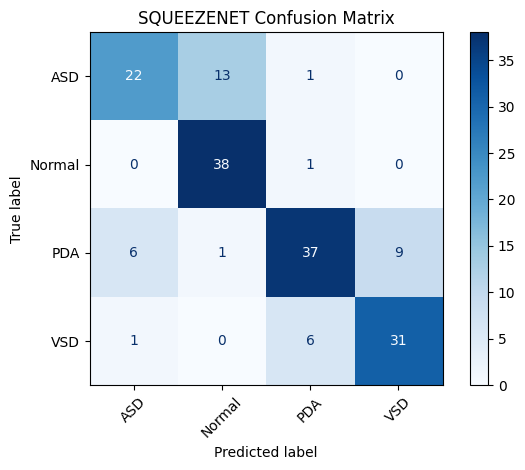

📁 Results saved: squeezenet_confusion_matrix.csv & squeezenet_classification_report.csv


In [ ]:
import torch
import numpy as np
from torchvision import datasets, transforms, models
from torch.utils.data import Subset, DataLoader
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, classification_report)
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import os

with open("config/config.yaml", 'r') as f:
    config = yaml.safe_load(f)

seed = config['training']['seed']
data_dir = config['data']['data_dir']
img_size = config['data']['image_size']
batch_size = config['data']['batch_size']


model_name = "squeezenet"  
checkpoint_path = "models/squeezenet1_1.pth"

torch.manual_seed(seed)
np.random.seed(seed)

# -----------------------------
# STEP 3: Dataset and split
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = dataset.classes
print(f"✅ Classes: {class_names}")

indices = list(range(len(dataset)))
np.random.shuffle(indices)
split = int(0.8 * len(indices))
val_indices = indices[split:]

val_dataset = Subset(dataset, val_indices)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print(f"✅ Validation set size: {len(val_dataset)}")

# -----------------------------
# STEP 4: Load model architecture
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if model_name == "squeezenet":
    model = models.squeezenet1_1(weights=None)  # <-- fix here
    model.classifier[1] = torch.nn.Conv2d(512, len(class_names), kernel_size=(1, 1))
    model.num_classes = len(class_names)
elif model_name == "resnet18":
    model = models.resnet18(weights=None)
    model.fc = torch.nn.Linear(model.fc.in_features, len(class_names))
elif model_name == "resnet50":
    model = models.resnet50(weights=None)
    model.fc = torch.nn.Linear(model.fc.in_features, len(class_names))
else:
    raise ValueError("Unsupported model name")

checkpoint = torch.load(checkpoint_path, map_location=device)

if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint:
    model.load_state_dict(checkpoint["model_state_dict"])
else:
    model.load_state_dict(checkpoint)

model.to(device)
model.eval()
print(f"✅ {model_name.upper()} model loaded from: {checkpoint_path}")


y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Validation Accuracy: {acc:.4f}")

print("\n📋 Classification Report:")
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title(f"{model_name.upper()} Confusion Matrix")
plt.tight_layout()
plt.show()

# Save results
pd.DataFrame(cm, index=class_names, columns=class_names).to_csv(f"{model_name}_confusion_matrix.csv")
pd.DataFrame(classification_report(y_true, y_pred, target_names=class_names, output_dict=True)).transpose().to_csv(f"{model_name}_classification_report.csv")
print(f"📁 Results saved: {model_name}_confusion_matrix.csv & {model_name}_classification_report.csv")
